In [ ]:
import sys
sys.path.append('../..')
import cortex_etl as c_etl
ma = c_etl.analysis_initial_processing("/gpfs/bbp.cscs.ch/project/proj83/home/isbister/physiology_2023/cortex_etl/configs/sscx_post_physiology/0-IC-IntialTest/0-IC-IntialTest-T1-etl3.yaml")

In [2]:
a = ma.hex0_spikes
a_name = "hex0_spikes"
ma.analyzers[a_name]

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# neuron_class = "L5_INH"
window_features_by_gid_and_trial = a.features.by_gid_and_trial.df.reset_index().etl.q(window='evoked_SOZ_25ms', neuron_class=c_etl.LAYER_EI_NEURON_CLASSES[:-1])
window_features_by_gid = a.features.by_gid.df.reset_index().etl.q(window='evoked_SOZ_25ms', neuron_class=c_etl.LAYER_EI_NEURON_CLASSES[:-1])

window_features_by_gid_and_trial = pd.merge(window_features_by_gid_and_trial, a.repo.simulations.df, on='simulation_id')
window_features_by_gid = pd.merge(window_features_by_gid, a.repo.simulations.df, on='simulation_id')

0
0
0
0
157
157
157
157
130
130
130
130
78
78
78
78
54
54
54
54
45
45
45
45
163
163
163
163
167
167
167
167
0
0
0
0


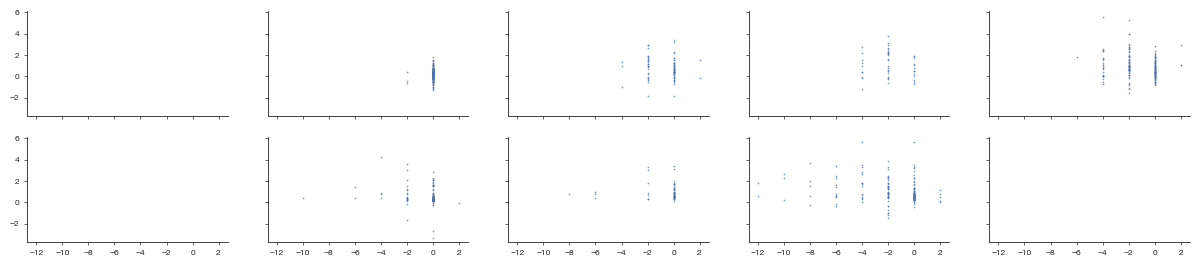

In [17]:
import numpy as np

def plot_ordered_mean_fst(a):

    fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(15, 3), sharex=True) #  sharey=True, 
    for col_i, neuron_class_grouping in enumerate(c_etl.LAYER_EI_NEURON_CLASS_GROUPINGS[:-1]):
        for row_i, neuron_class in enumerate(neuron_class_grouping):
            if (neuron_class == "L1_INH"): 
                row_i = 1
            ax = axes[row_i][col_i]
            window_nc_features_by_gid = window_features_by_gid.etl.q(neuron_class=neuron_class)
            for ind, simulation_row in a.repo.simulations.df.iterrows():  
                test_df = window_nc_features_by_gid.etl.q({"simulation_id": simulation_row['simulation_id'], "mean_spike_counts": {"ge": 0.2}})
                mean_FSTs = np.asarray(test_df['first_spike_time_means_cort_zeroed'])
                ax.scatter(mean_FSTs[np.argsort(mean_FSTs)], test_df['neuron_class_index'], s=.1)
            if (row_i == 1): ax.set_xlabel('Time (ms)')
            ax.set_title(neuron_class)
    plt.show()
    

    
def plot_pfr_vs_mean_fst(a, pfrs):
    fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(15, 3), sharex=True, sharey=True) #   
    for col_i, neuron_class_grouping in enumerate(c_etl.LAYER_EI_NEURON_CLASS_GROUPINGS[:-1]):
        for row_i, neuron_class in enumerate(neuron_class_grouping):
            if (neuron_class == "L1_INH"): 
                row_i = 1
            ax = axes[row_i][col_i]
            window_nc_features_by_gid = window_features_by_gid.etl.q(neuron_class=neuron_class)
            
            thresholded_window_nc_features_by_gid = window_nc_features_by_gid.etl.q({"desired_connected_proportion_of_invivo_frs": pfrs, "mean_spike_counts": {"ge": 0.2}})
            
            for neuron_class_index in thresholded_window_nc_features_by_gid.neuron_class_index.unique():
                test_df = window_nc_features_by_gid.etl.q(desired_connected_proportion_of_invivo_frs=pfrs, neuron_class_index=neuron_class_index)
                ax.plot(test_df['first_spike_time_means_cort_zeroed'], pfrs, lw=0.1)
    
            thresholded_pfr_means = thresholded_window_nc_features_by_gid.groupby(['desired_connected_proportion_of_invivo_frs']).mean(['first_spike_time_means_cort_zeroed'])['first_spike_time_means_cort_zeroed']
            ax.plot(thresholded_pfr_means, thresholded_pfr_means.reset_index().desired_connected_proportion_of_invivo_frs.unique(), lw=1)

            ax.set_xlabel('Time (ms)')
            ax.set_ylabel('$P_{FR}$')
    plt.show()
    
def scatter_2pfr_mean_fsts(a, pfrs, plot_type='scatter'):
    
    fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(15, 3), sharex=True, sharey=True) #   
    for col_i, neuron_class_grouping in enumerate(c_etl.LAYER_EI_NEURON_CLASS_GROUPINGS[:-1]):
        for row_i, neuron_class in enumerate(neuron_class_grouping):
            if (neuron_class == "L1_INH"): 
                row_i = 1
            ax = axes[row_i][col_i]
            window_nc_features_by_gid = window_features_by_gid.etl.q(neuron_class=neuron_class)
            
            thresholded_window_nc_features_by_gid = window_nc_features_by_gid.etl.q({"desired_connected_proportion_of_invivo_frs": pfrs, "mean_spike_counts": {"ge": 0.2}})
    
            df_lower = thresholded_window_nc_features_by_gid.etl.q(desired_connected_proportion_of_invivo_frs=pfrs[0])
            df_higher = thresholded_window_nc_features_by_gid.etl.q(desired_connected_proportion_of_invivo_frs=pfrs[1])

            intersecting_gids = np.intersect1d(df_lower.gid, df_higher.gid)
            
            
            intersecting_mean_fs_lower = df_lower.etl.q(gid=intersecting_gids)['first_spike_time_means_cort_zeroed'].values
            intersecting_mean_fs_higher = df_higher.etl.q(gid=intersecting_gids)['first_spike_time_means_cort_zeroed'].values
            
            if (plot_type == 'scatter'):
                ax.scatter(intersecting_mean_fs_lower, intersecting_mean_fs_higher, s=0.1)

                ax.plot([5.0, 25.0], [5.0, 25.0], c='k', ls='--', lw=.2)
                if (row_i == 1): ax.set_xlabel('Time (ms)')
                ax.set_ylabel('Time (ms)')
                ax.set_title(neuron_class)

            if plot_type == 'diff_hist':
                ax.hist(intersecting_mean_fs_lower - intersecting_mean_fs_higher, bins=np.arange(-10, 10, 0.5))
                ax.set_title(neuron_class)
                if (row_i == 1): ax.set_xlabel("Time difference (ms)")
                ax.set_ylabel("Frequency")
                
            if plot_type == 'spont_fr_diff_vs_fs_diff':
                
                simulation_id_lower = a.repo.simulations.df.etl.q(desired_connected_proportion_of_invivo_frs=pfrs[0]).iloc[0].simulation_id
                simulation_id_higher = a.repo.simulations.df.etl.q(desired_connected_proportion_of_invivo_frs=pfrs[1]).iloc[0].simulation_id
                
                spont_frs_nc_lower_intersecting = a.features.by_gid.df.reset_index().etl.q(window='conn_spont', neuron_class=neuron_class, simulation_id=simulation_id_lower, gid=intersecting_gids)['mean_firing_rates_per_second'].values
                spont_frs_nc_higher_intersecting = a.features.by_gid.df.reset_index().etl.q(window='conn_spont', neuron_class=neuron_class, simulation_id=simulation_id_higher, gid=intersecting_gids)['mean_firing_rates_per_second'].values
                
                ax.scatter(spont_frs_nc_lower_intersecting - spont_frs_nc_higher_intersecting, intersecting_mean_fs_lower - intersecting_mean_fs_higher, s=0.1)
    

    
plot_ordered_mean_fst(a)
plot_pfr_vs_mean_fst(a, [0.1, 0.3, 0.5])
scatter_2pfr_mean_fsts(a, [0.1, 0.5], plot_type='scatter')
scatter_2pfr_mean_fsts(a, [0.1, 0.5], plot_type='diff_hist')
scatter_2pfr_mean_fsts(a, [0.1, 0.5], plot_type='spont_fr_diff_vs_fs_diff')
  

In [ ]:
soma_ma = c_etl.analysis_initial_processing("../configs/6-O1-MPScan/6-O1-MPScan-0-5x3x2-2sims.yaml") #, loglevel="ERROR

In [ ]:
# def MeanFSTOrdering2(simulations):
#     plt.figure()
#     initial_ordering = []
#     for ind, simulation_row in simulations[::-1].iterrows():    
#         test_df = window_nc_features_by_gid.etl.q({"simulation_id": simulation_row['simulation_id'], "mean_spike_counts": {"ge": 0.4}})
# #         test_df = window_nc_features_by_gid.etl.q(simulation_id=simulation_row['simulation_id'])
#         plt.gca().set_title(simulation_row['simulation_string'])
#         mean_FSTs = np.asarray(test_df['first_spike_time_means_cort_zeroed'])
#         if (len(initial_ordering) == 0):
#             initial_ordering  = np.argsort(mean_FSTs)
#         plt.scatter(mean_FSTs[initial_ordering], range(len(initial_ordering)), s=.1)
#     plt.show()
    
# MeanFSTOrdering2(test_sims)
#     test_df = window_nc_features_by_gid_and_trial.etl.q(simulation_id=simulation_row['simulation_id'])
#     plt.figure()
#     plt.gca().set_title(simulation_row['simulation_string'])
#     plt.scatter(test_df['first'], test_df['neuron_class_index'], s=.1)
#     plt.gca().set_xlim([10.0, 25.0])
#     plt.show()
    
#     if (ind > 0):
#         break